# Dataset 和 Dataloader

参考：[Datasets & Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

`torch.autograd` 实现自动微分

处理数据样本的代码可能会变得混乱且难以维护；理想情况下，希望数据集代码与模型训练代码解耦，以获得更好的可读性和模块化。PyTorch 提供了两个数据原语：`torch.utils.data.DataLoader` 和 `torch.utils.data.Dataset`，它们允许使用预加载的数据集以及自定义的数据。`Dataset` 存储样本及其相应的标签，`DataLoader` 在 `Dataset` 周围包装一个可迭代对象以方便访问样本。

PyTorch 域库提供了许多预加载的数据集（比如 {term}`Fashion MNIST`），这些数据集继承了 `torch.utils.data.Dataset` 的子类，并实现了特定于特定数据的函数。它们可以用于模型原型（prototype）和基准测试（benchmark）。细节见 [图像数据集](https://pytorch.org/vision/stable/datasets.html)，[文本数据集](https://pytorch.org/text/stable/datasets.html) 和[音频数据集](https://pytorch.org/audio/stable/datasets.html)。

## 加载 `Dataset`

下面是如何从 TorchVision 加载 Fashion MNIST 数据集的示例。Fashion MNIST 是 Zalando 文章图像的数据集，包含 $60\,000$ 个训练样本和 $10\,000$ 个测试样本。

加载 Fashion MNIST 数据集的参数：

- `root` 是存储 train/test 数据的路径
- `train` 指定训练或测试数据集
- `download=True` 如果数据在根目录下不可用，则从互联网上下载数据
- `transform` 和 `target_transform` 指定特征和标签变换

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


root = '../../datasets'

training_data = datasets.FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=ToTensor()
)

C:\Users\xinet\.conda\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 迭代和可视化 `Dataset`

- 可以像 `training_data[index]` 那样手动索引数据集。
- 使用 `matplotlib` 可视化训练数据中的一些样本。

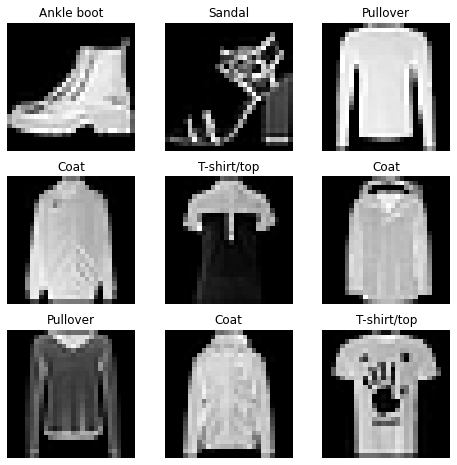

In [2]:
labels_map = training_data.classes # 获取类别列表
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 创建自定义数据集

自定义数据集类必须实现三个函数：`__init__`， `__len__` 和 `__getitem__`。比如 FashionMNIST 图像存储在一个目录 `img_dir` 中，它们的标签分别存储在一个 CSV 文件 `annotations_file` 中。

In [3]:
import os
import pandas as pd
from torchvision.io import read_image


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### `__init__`

`__init__` 函数在实例化 `Dataset` 对象时运行一次。初始化包含图像、标注文件和这两种变换的目录。

`labels.csv` 文件看起来像这样：

```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

### `__len__`

`__len__` 函数返回数据集中的样本数量。

### `__getitem__`

`__getitem__` 函数从数据集的给定索引 `idx` 处加载并返回一个样本。基于索引，它识别图像在磁盘上的位置，使用 `read_image` 将其转换为张量，从在 `self.img_labels` 中的 csv 数据检索相应的标签，调用它们的变换函数（如果适用），并返回张量图像和相应的标签组成的元组。

## 使用 `DataLoader` 准备训练数据

`Dataset` 检索我们的数据集的特征和标签，且一次一个样本。在训练模型时，通常希望以“小批量”的方式通过样本，在每个 epoch 重新编排数据以减少模型过拟合，并使用 Python 的 `multiprocessing` 来加快数据检索。

`DataLoader` 是一个可迭代对象，它在一个简单的 API 中为我们抽象了这种复杂性。

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 遍历 `DataLoader`

已经将该数据集加载到 `Dataloader` 中，并可以根据需要遍历该数据集。下面的每次迭代返回一批 `train_features` 和 `train_labels`(分别包含 `batch_size=64` 个特征和标签)。因为指定了 `shuffle=True`，所以在遍历所有批次之后，数据被打乱(为了更细粒度地控制数据加载顺序，请查看 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler))。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


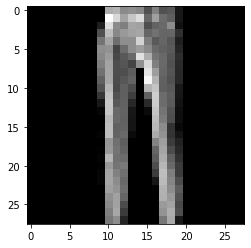

Label: 1


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")